Text Classification Notebook

Goal to create classify reviews into their correct star using text properties

In [1]:
import json
import pandas as pd
from num2words import num2words
import contractions
import nltk
import spacy

Read raw review data

In [2]:
alberta = pd.read_csv('albertaRestrauntReviews.csv')
alberta_explode = alberta.assign(categories = alberta.categories.str.split(', ')).explode('categories')
albertaClean = alberta[['business_id', 'name', 'address', 'stars', 'is_open', 'review_count', 'attributes', 'categories', 'review_stars', 'text', 'date']]
albertaClean

,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",3,So much to like about this place--the beautifu...,2012-11-06 23:35:15
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,I'm not a coffee connoisseur so I'm not review...,2013-05-28 23:16:30
2,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"I really loved it here, makes me wish I lived ...",2013-09-04 19:49:33
3,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",2,The kids who work at Roast are friendly. They...,2013-07-14 21:38:06
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"With a Toast to Roast, I say welcome to the E-...",2012-09-11 23:54:24
...,...,...,...,...,...,...,...,...,...,...,...
68877,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,YES.\n\nI have been to 2 other comparable Midd...,2017-03-13 19:47:08
68878,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,We had the beef plate medium rare that was mou...,2018-04-14 23:41:03
68879,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,Excellent Mediterranean food! Always cooked to...,2018-06-19 02:02:41
68880,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",4,This was my first visit to West Side Kebab Hou...,2017-03-24 01:46:31


Create business dataframe storing all reviews as a list of list

In [3]:
businessReview = alberta.groupby(by="business_id").aggregate({'name' : 'first',
                                                              'text' : lambda x: (list(x)),
                                                        'review_count' : 'first',
                                                        'categories' :'first'}).reset_index()

print("Dataframe with the restruant and the reviews all grouped into a list of lists with the number of reviews incldued as well.")
businessReview[['name', 'text', 'review_count', 'categories']].sort_values(by='review_count', ascending=False)

Dataframe with the restruant and the reviews all grouped into a list of lists with the number of reviews incldued as well.


,name,text,review_count,categories
584,Duchess Bake Shop,"[I love, love the baked goods in this bakery. ...",486,"Patisserie/Cake Shop, Food, Restaurants, Baker..."
1635,SugarBowl,[Met a friend for breakfast and we shared the ...,435,"Juice Bars & Smoothies, American (New), Cafes,..."
1792,Tres Carnales Taqueria,[Quite good tacos - standard tacqueria - these...,429,"Restaurants, Mexican"
2030,Meat,"[Wowza, the BEST mac and cheese I've had in my...",420,"Southern, Barbeque, Restaurants, Breakfast & B..."
1735,Padmanadi Vegetarian Restaurant,[I'm so glad my friend introduced me to this p...,271,"Restaurants, Vegan, Indonesian, Vegetarian"
...,...,...,...,...
1949,Joe's Famous Donair & Burger Ltd,[Visited Joe's Famous Donair 2 times this past...,5,"Burgers, Restaurants, Fast Food"
637,Saigon Delights,[We came in and ordered. The waiter waits unti...,5,"Vietnamese, Restaurants"
650,Garage Burger Bar & Grill,[The walls of this downtown burger joint are p...,5,"Nightlife, Restaurants, Burgers, Bars"
657,Fine Pizza and Donair,[Craving late-night munchies? This place has g...,5,"Pizza, Restaurants, Food, Burgers, Halal, Donairs"


In [4]:
businessReviewCopy = businessReview.copy(deep=True)


In [5]:
allReviewsList = list(businessReview["text"])

In [6]:
print("tokenize the first pizza resturants reviews")
for i in range(len(allReviewsList)):
    for j in range(len(allReviewsList[i])):
        # print(i, j)
        review = allReviewsList[i][j].split(" ")
        allReviewsList[i][j] = review

tokenize the first pizza resturants reviews


In [7]:
tok = list(businessReviewCopy['text'])

In [8]:
newList = []
for i in tok:
    restList = []
    for j in i:
        str1 = ' '.join([str(elem) for elem in j])
        # print(str1)
        restList.append(str1)
    newList.append(restList)

In [9]:
businessReview['rawData'] = newList

Cell to intially clean data

In [10]:
from num2words import num2words
import contractions

reviewList = businessReview['rawData']

cleanText = []
j =0
for bus in reviewList:
    busCleanReviews = []
    for i in bus:
        # print(i)
        noPunc = i.lower().replace(".","").replace("'s", "s")
        noPunc = noPunc.replace(",", "").replace("\n", " ")
        noPunc = noPunc.replace("(", "").replace(")", "").replace("  ", " ").replace("!", "").replace("&", "").replace(":", "").replace("?", "").replace("-", "")
        #noPunc = noPunc.replace("\'".replace(" ", ""), "")
        noPunc = noPunc.replace('"', "")
        noPunc = noPunc.replace('*', "")
        # result = ''.join([i for i in noPunc if not i.isdigit()]).replace("  ", " ")
        # if(result != ""):
        expanded_words = []   
        for word in noPunc.split():
        # using contractions.fix to expand the shortened words
            expanded_words.append(contractions.fix(word))  
        
        expanded_text = ' '.join(expanded_words)
        busCleanReviews.append(expanded_text)
    cleanText.append(busCleanReviews)

Tokenize cleaned text

In [11]:
##From Class ##
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

cleanTokens = []
for bus in cleanText:
    busCleanTokens = []
    for i in bus:
        busCleanTokens.append(word_tokenize(i))
    
    cleanTokens.append(busCleanTokens)

Check tokens to make sure clean 

In [12]:
for i in cleanTokens:
    for j in i:
        l = 0
        for k in j:
            j[l] = k.replace("+", "")
            l+=1
            if(k == "$" or k.isdigit()):
                j.remove(k)

In [13]:
businessReview["cleanedTokens"] = cleanTokens

Clean review text

In [14]:
reviewSeperate = list(albertaClean['text'])

cleanTextSeperate = []
j =0
for i in reviewSeperate:
    # seperateCleanReviews = []
    # for i in bus:
        # print(i)
    noPunc = i.lower().replace(".","").replace("'s", "s").replace("$", "")
    noPunc = noPunc.replace(",", "").replace("\n", " ")
    noPunc = noPunc.replace("(", "").replace(")", "").replace("  ", " ").replace("!", "").replace("&", "").replace(":", "").replace("?", "").replace("-", " ")
    noPunc = noPunc.replace("\'".replace(" ", ""), "")
    noPunc = noPunc.replace('"', "")
    noPunc = noPunc.replace("/", "").replace("%", "").replace("~", "").replace(":", "").replace(";", "").replace("...", "")
    noPunc = noPunc.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
    noPunc = noPunc.replace("]", "").replace("^", "").replace("¢", "").replace("_", "").replace("'", "")
    noPunc = noPunc.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
    result = ''.join([i for i in noPunc if not i.isdigit()]).replace("  ", " ")
    result = result.replace('*', "")
    # if(result != ""):
    expanded_words = []   
    for word in result.split():
    # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))  
    
    expanded_text = ' '.join(expanded_words)
    cleanTextSeperate.append(expanded_text)

Tokenize reviews

In [15]:
##From Class ##
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

cleanTokensSeperate = []
for bus in cleanTextSeperate:
    cleanTokensSeperate.append(word_tokenize(bus))

In [16]:
albertaClean["cleanTokens"] = cleanTokensSeperate

C:\Users\User\AppData\Local\Temp\ipykernel_13848\3390862322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean["cleanTokens"] = cleanTokensSeperate


Create average ratings for each business

In [17]:
businessStars = albertaClean.groupby(by="business_id").aggregate({'review_stars' : lambda x: list(x)})
businessStars

,review_stars
business_id,
--7PUidqRWpRSpXebiyxTg,"[1, 2, 3, 1, 1, 1, 2, 4, 3, 1, 1, 1]"
-2oyyfOSHs1UElr3Dc1aKQ,"[5, 4, 5, 4, 3, 3, 4, 4, 4, 4, 5, 4]"
-3GD07waps96fB_okEwFqw,"[4, 4, 5, 5, 1, 2, 5, 4, 4, 5, 3, 1, 4, 3, 5, ..."
-4lNMmoW7gRxkH0c2dfXfA,"[5, 1, 5, 5, 5]"
-4qgeqxb2hKe3dUUH__j8Q,"[4, 3, 4, 3, 5, 5, 4, 4, 3, 4, 5, 4, 4, 4, 5, ..."
...,...
zpXKeyg8GD2Z27Biaeqo8A,"[2, 4, 3, 1, 1, 1, 1]"
zun3rAOoiAyeIL3JIB4eYg,"[2, 3, 5, 4, 1, 5, 3, 5, 1, 4, 5, 4, 4, 5, 1, ..."
zx7XemDyT296vmKnFtZSyQ,"[3, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 5]"


Merge ratings with business dataframe

In [18]:
finalDf = pd.merge(businessReview, businessStars, on="business_id")

In [19]:
avgRat = []
for i in list(finalDf['review_stars']):
    totalStars = 0
    for j in i:
        totalStars+= j
    avgStars = totalStars / len(i)
    avgRat.append(avgStars)

finalDf['avgRating'] = avgRat

Series of fucntions to create ngrams of any text

Function adapted from:


Albert Au Yeung. Generating n-grams from sentences in python: Albert Au Yeung. Retrieved March 18, 2023 from https://albertauyeung.github.io/2018/06/03/generating-ngrams.html/ 

In [20]:
from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

plt.rcParams["figure.figsize"] = [16, 9]


def create_ngrams(token_list, nb_elements):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)



def create_ngramsList(token_list, nb_elements):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    ngramList = []
    for i in ngrams:
        ngramList.append(" ".join(i))
        
    return ngramList

def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    ngrams_number : int
    number_top_words : int
        output dataframe length
    Returns
    -------
    DataFrame
        Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

Final check on all tokens to ensure all unwanted characters are removed

In [21]:
checkList = list(albertaClean['cleanTokens'])
checkList2 = list(finalDf['cleanedTokens'])

In [22]:
count = 0
newList = []
index = 0
for i in checkList:
    revList = []
    for j in i:
        if(j.isalpha() == False):
            count+=1
            # print(j, index)
            j = j.strip()
            newJ = j.replace("/", "").replace("%", "").replace("'", " ").replace("~", "").replace(":", "").replace(";", "").replace(" ", "").replace("...", "")
            newJ = newJ.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
            newJ = newJ.replace("]", "").replace(",", "").replace("^", "").replace("′", "").replace("¢", "").replace("_", "").replace("'", "").replace("，", "")
            newJ = newJ.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
            newJ = newJ.strip()
            if(len(newJ) != 0):
                revList.append(newJ)
        else:
            revList.append(j)
    newList.append(revList)
    index+=1
print(count)

168


In [23]:
count = 0
index = 0
finalList2 = []
for i in newList:
    revFinal = []
    for j in i:
        if(j.isalpha() == False):
            count+=1
            print(j)
        else:
            revFinal.append(j)
    finalList2.append(revFinal)
print(count)

edmonton​
お店の中はとっても落ち着いててリラックス出来るし、何と言っても、、、
\
煎饼果子加酥脆鸡蛋灌饼加午餐肉羊肉串羊腰子。水煎包金针菇超辣。肉筋也比较辣面筋是提前腌过的。很正好吃
⁣
⁣
owner⁣
owner⁣
​​spring
us‍
‍
resturant。this
\for
feeling​
definitely​
unique​
restaurant​
thin​
many​
different​
pepperoni​
homemade​
original​
does​
recommend​
something​​g
accommodate​
dinner​
japanese​
‍
its​
char​
‍
\
going​
アジアテイストのカフェなので店員さんもお客さんもアジア人が多かったです。
とても親切な対応をしていただきました。
メニューも豊富で決めるのにとても時間がかかってしまいましたが、結局抹茶暑い夏には特にぴったりのカフェだと思います。
aveなので、バスでも行きやすく最高
pot涮涮鍋店位於亞省愛民頓市的唐人街經營至今已跨越七個年頭了。開業之初餐館只做晚市任食火鍋營業時間至凌晨是區內知名宵夜夜店。近年食肆延長營業時間除了提供全日任點任食火鍋外更加設午市及宵夜自選個人火鍋套餐劃一價錢一人一鍋包括免費湯底
種食材任選款及自助醬料吧非常適合單身人士或一大班朋友齊齊享用。
我個人特別喜歡一人一鍋形式的打邊爐除了較大家圍著同一個爐的傳統火鍋更衛生外更可按個人喜好選擇不同湯底和配料。其實火鍋湯底有人愛辣亦有人怕辣火鍋料方面更各有喜惡愛肉愛素彼此不同其中羊肉更非人人能夠接受所以一人一鍋確實是個偉大發明啊這家店為配合這個理念店內餐桌每個座位都裝設獨立調節熱量的內藏爐頭安放配合個人大小的湯鍋。同時派發每人一張表格按個人喜好勾出自選湯底及火鍋料交服務員下單再到自助醬料吧調配個人專用口味的醮醬完全不受他人的影響
than​
\mr
‍
‍
‍
​
​
⁣
⁣
⁣
left）
¾
¼
無意間路過看見試營運就試試蠻多服務生也都很親切很乾淨很明亮東西好吃種類也多。可是覺得有點小貴不過如果之後品質不變一樣會再光顧xd
‍
⁄
°
\lovers
​​denne
牛肉河粉的牛肉肉質鮮嫩配上生豆苗、九層塔與檸檬提味湯頭很美味。蝦仁炒時蔬有花椰菜四季豆蘑菇紅

If this value is 0 we know all reviews only contain letters

In [24]:
count = 0
index = 0
for i in finalList2:
    for j in i:
        if(j.isalpha() == False):
            count+=1
            print(j)
print(count)

0


In [25]:
count = 0
newList = []
index = 0
for i in checkList2:
    revList = []
    for j in i:
        rev2List = []
        for k in j:
            if(k.isalpha() == False):
                count+=1
                # print(j, index)
                k = k.strip()
                newJ = k.replace("/", "").replace("%", "").replace("'", " ").replace("~", "").replace(":", "").replace(";", "").replace(" ", "").replace("...", "")
                newJ = newJ.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
                newJ = newJ.replace("]", "").replace(",", "").replace("^", "").replace("′", "").replace("¢", "").replace("_", "").replace("'", "").replace("，", "")
                newJ = newJ.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
                newJ = newJ.strip()
                if(len(newJ) != 0):
                    rev2List.append(newJ)
            else:
                rev2List.append(k)
        revList.append(rev2List)
    newList.append(revList)
    index+=1
print(count)

53462


In [26]:
count = 0
index = 0
finalList = []
for i in newList:
    revList = []
    for j in i:
        rev2List = []
        for k in j:
            if(k.isalpha() == False):
                count+=1
                print(k)
            else:
                rev2List.append(k)
        revList.append(rev2List)
    finalList.append(revList)

print(count)

9am
14
34
12
3
4245
1414
12
20
2pc
2200
16
40
27
10min
‍
1pc
20
2020
1st
9am
10
5pm
699
30
4
6
7eleven
2nd
7lb
5mins
30
2020
97th
c2
80s
5
8
8
30
15
2
200
3000
1000
2500
350
20
20
7am9pm
15
500g
24
340g
9pm
1360
124st
598
2
2ndcups
350
375
350
495
495
7am9pm
20
15
352
20
30
5
45
55
455
45
35
8
1010
170
900pm
30
30
165
60th
60th
4
330am
5
3rd
15
1010
7oz
5
2nd
16
10
9
14oz
14oz
180
12
23ave
$
$
10pm
913
iwanttostudyon4thfloorcameronlibraryattheu
10
1090
3035ish
3
7
1
10
1
12
12
2015
850
three10
three10
20
2piece
5
60
366
124th
32
$
$
$
$
6pm
10
16
6
17th
10
15
$
25
124st
107ave
10
900
18th
1050
600
750
7
10
1015am
34
12
2314
$
2019
169
10
15
13
21
45
230pm
1795
150
075
34th
1199
50ea
1ea
chicken999
15
1699
110can
700lb
34th
2pm
14
15
6
$
3x
b5
109st
112st
8pm
8pm
715pm
400
a2
700
1500
b7
1300
b8
1300
990
1650
6pm
43
12
1pm
825
450
3
2500
3pm
9am
50
40ish
15
6
6
2014
10oz
7oz
5pm
7pm
6500
14
6yearold
1050
80s
75
7
6
18
5
275
9
40
30x30
$
80
80s
90s
10
90s
4pm
9
4
80s
799
$
56pm
250
36
12

In [27]:
for i in finalList:
    for j in i:
        for k in j:
            if(k.isalpha() == False):
                print(k)

In [28]:
finalDf['cleanedTokens'] = finalList

In [29]:
albertaClean['cleanTokens'] = finalList2

C:\Users\User\AppData\Local\Temp\ipykernel_13848\3443118404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTokens'] = finalList2


Text processed and all clean

In [14]:
!pip install textblob


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Use Vader and TextBlob for sentiment values

In [30]:
import pandas as pd
from textblob import TextBlob
import nltk
nltk.download('all')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

In [31]:
makeText = list(albertaClean['cleanTokens'])

Create clean text

In [20]:
joinedText = []
for busRev in makeText:
    newList = " ".join([word for word in busRev])
    joinedText.append(newList)
albertaClean['cleanText'] = joinedText

C:\Users\User\AppData\Local\Temp\ipykernel_25408\1382171558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanText'] = joinedText


In [32]:
from nltk.corpus import stopwords

nltk.download('stopwords')

language = "english"

stopwords = list(set(stopwords.words(language)))

# reviewsBiTokensStop = [word for word in restruantTokens if word not in stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
reviewsTokensStop = [word for rev in makeText for word in rev if word not in stopwords]


Create bi and tri grams

In [34]:
bg = []
bg = create_ngramsList(reviewsTokensStop, 2)

In [35]:
tri = []
tri = create_ngramsList(reviewsTokensStop, 3)

Use FreqDist to investiage term frequency

In [36]:
from nltk.probability import FreqDist

In [37]:
fdist = FreqDist(word for word in reviewsTokensStop)

In [38]:
fdist2 = FreqDist(bi for bi in bg)

In [39]:
fdist3 = FreqDist(t for t in tri)

In [40]:
fdist.most_common(20)

[('food', 58409),
 ('good', 44980),
 ('place', 39225),
 ('great', 32236),
 ('like', 29891),
 ('service', 28794),
 ('would', 27496),
 ('one', 26726),
 ('time', 25235),
 ('really', 23184),
 ('go', 22531),
 ('back', 21824),
 ('get', 21739),
 ('restaurant', 21563),
 ('also', 19647),
 ('chicken', 19413),
 ('menu', 19158),
 ('ordered', 18819),
 ('us', 17487),
 ('order', 17305)]

In [41]:
fdist2.most_common(10)

[('go back', 3722),
 ('first time', 3715),
 ('come back', 2955),
 ('really good', 2945),
 ('food good', 2549),
 ('pretty good', 2390),
 ('next time', 2319),
 ('great place', 2072),
 ('great food', 1965),
 ('highly recommend', 1896)]

In [31]:
fdist3.most_common(10)

[('would go back', 554),
 ('green onion cakes', 478),
 ('definitely come back', 467),
 ('definitely go back', 444),
 ('wait go back', 417),
 ('would definitely recommend', 393),
 ('go back try', 388),
 ('would come back', 385),
 ('come back try', 384),
 ('sweet potato fries', 365)]

Function from lecture to extract the polarity of a review using text blob

In [ ]:
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# get polarity and subjectivity
albertaClean['blob_polarity'], albertaClean['blob_subjectivity'] = zip(*albertaClean.iloc[:, 12].apply(get_textblob_sentiment))

albertaClean.head()

Function from lecture to extract the polarity of a review using vader 

In [ ]:
def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# get vader sentiment score
albertaClean['vader_score'] = albertaClean.iloc[:, 12].apply(get_vader_sentiment)

albertaClean.head()



added common words related to resturants removed

In [42]:
stopwords = stopwords + ["go", "recommend"] + ["like", "back", "good", "get", "even"] + ['food', 'place', 'us', 'order', 'would', 'restaurant', 'meal', 'got', 'came', 'could', 'went', 'said', 'table', 'asked', 'really', "never", "worst", "ever"] + ['food', 'service', 'place', 'us', 'order', 'would', 'restaurant', 'meal', 'got', 'came', 'could', 'went', 'said', 'table', 'asked', 'really', "never", "worst", "ever"]
stopwords = stopwords + ["highly" , "delicious", "definitely", "better", "one", "always", "well", "best"]
stopwords = stopwords + ["edmonton", "perfect", "perfectly", "great", "awesome", "nice", "bad", "top", "every"]
stopwords = stopwords +  ["favorite", "favourite", "super", "nothing", "also", "try", "amazing", "love", "keep", "coming"]
stopwords = stopwords + ["terrible", "disappointed", "everything", "excellent", "fantastic"]


In [36]:
len(stopwords)

237

In [35]:
stopwords = (list(set(stopwords)))


remove stopwords and added extra words

In [37]:
noStops = []

for rev in makeText:
    busRev = []
    for word in rev:
        if word not in stopwords:
            busRev.append(word)

    noStops.append(busRev)

In [36]:
len(noStops)

68882

In [38]:
albertaClean['cleanTokensNoStop'] = noStops

C:\Users\User\AppData\Local\Temp\ipykernel_25408\1708118382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTokensNoStop'] = noStops


In [39]:
joinedText = []
for busRev in noStops:
    newList = " ".join([word for word in busRev])
    joinedText.append(newList)
albertaClean['cleanTextNoStop'] = joinedText

C:\Users\User\AppData\Local\Temp\ipykernel_25408\3679722030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTextNoStop'] = joinedText


Begininning of classifcation using TF-IDF representation

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import numpy as np
import shap

4 and 5 star reviews are Postivie and < 3 is negative

In [41]:
binaryClass = []
for i in list(albertaClean['review_stars']):
    if i > 3:
        binaryClass.append("Positive")
    else:
        binaryClass.append("Negative")
 
albertaClean['binRating'] = binaryClass


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Create Dataframe with 1,2 and 5 star reviews to classify

In [43]:
lowHigh = albertaClean[albertaClean['review_stars'] == 1].append(albertaClean[albertaClean['review_stars'] == 2]).append(albertaClean[albertaClean['review_stars'] == 5])

C:\Users\User\AppData\Local\Temp\ipykernel_13848\1943939945.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lowHigh = albertaClean[albertaClean['review_stars'] == 1].append(albertaClean[albertaClean['review_stars'] == 2]).append(albertaClean[albertaClean['review_stars'] == 5])
C:\Users\User\AppData\Local\Temp\ipykernel_13848\1943939945.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lowHigh = albertaClean[albertaClean['review_stars'] == 1].append(albertaClean[albertaClean['review_stars'] == 2]).append(albertaClean[albertaClean['review_stars'] == 5])


In [43]:
lowHigh.reset_index(inplace=True)

create training and test data

In [44]:
corpus_train, corpus_test, y_train, y_test = train_test_split(lowHigh['cleanTextNoStop'], lowHigh['binRating'], test_size=0.2, random_state=7)

Use TF-IDF vectorizer on training and test data

In [45]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(2,2))
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

Use logistic Regression Model

In [426]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [ ]:
y_pred = model.predict(X_test)

Results

In [428]:

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.95      0.33      0.49      2826
    Positive       0.70      0.99      0.82      4591

    accuracy                           0.74      7417
   macro avg       0.83      0.66      0.65      7417
weighted avg       0.80      0.74      0.69      7417

[[ 923 1903]
 [  47 4544]]


Modified functions from lectures to mine features from the text reviews to use in a clasifier

In [46]:
#From Lecture

import nltk
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer
import string

# initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def extract_features(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())
    
    # Get parts of speech for each token
    pos_tags = pos_tag(tokens)
    
    # Count occurrences of positive and negative words
    positive_words = 0
    negative_words = 0
    for word in tokens:
        sentiment = analyzer.polarity_scores(word)
        if sentiment['compound'] >= 0.5:
            positive_words += 1
        elif sentiment['compound'] <= -0.5:
            negative_words += 1
    
    # Count occurrences of adjectives and adverbs
    adj_count = 0
    adv_count = 0
    for word, pos in pos_tags:
        if pos == 'JJ':
            adj_count += 1
        elif pos == 'RB':
            adv_count += 1
    
    # Calculate polarity score
    polarity_score = analyzer.polarity_scores(text)['compound']
    
    # Check for named entities
    named_entities = nltk.ne_chunk(pos_tag(word_tokenize(text)), binary=False)
    named_entity_presence = False
    for chunk in named_entities:
        if hasattr(chunk, 'label') and chunk.label() in ['PERSON', 'ORGANIZATION', 'LOCATION']:
            named_entity_presence = True
    
    # Combine features into a single feature vector
    feature_vector = [positive_words, negative_words, adj_count, adv_count, polarity_score, named_entity_presence]
    
    return feature_vector


Create classes to classify data

In [47]:
albertaClean['rating'] = albertaClean['review_stars'].replace({1:'1 Rating', 2:'Low Rating', 3:'Low Rating',
                                           4:'High Rating', 5:'5 Rating'})
albertaClean.rating.value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 Rating       22846
High Rating    21377
Low Rating     17073
1 Rating        7586
Name: rating, dtype: int64

1 vs 5 and 2 vs 4 sample sets to use in classifer (6000 from each)

In [48]:
fiveStars = albertaClean[albertaClean['review_stars'] == 5].sample(n=6000)
oneStar = albertaClean[albertaClean['review_stars'] == 1].sample(n=6000)

In [32]:
fourStars = albertaClean[albertaClean['review_stars'] == 4].sample(n=6000)
twoStar = albertaClean[albertaClean['review_stars'] == 2].sample(n=6000)

In [49]:
mergedFiveOne = fiveStars.append(oneStar)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [33]:
mergedFourTwo= fourStars.append(twoStar)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Extract various features:

- Punctuation percentage
- Common word counts




In [ ]:
feature_vectors24 = []
textAlb24 = list(mergedFourTwo['cleanText'])
ratAlb24 = list(mergedFourTwo['review_stars'])
count = 0
for i in range(len(textAlb24)):
    text = textAlb24[i]
    feature_vector24 = extract_features(text)
    class_label = ratAlb24[i]
    feature_vector24.append(class_label)
    feature_vectors24.append(feature_vector24)
    count+=1
    print(count)

feature_names24 = ['positive_words', 'negative_words', 'adj_count', 'adv_count', 'polarity_score', 'named_entity_presence', 'class_label']
feature_df24 = pd.DataFrame(feature_vectors24, columns=feature_names24)

feature_df24.head()

In [43]:
feature_df24.to_csv('twoFourStar.csv')

In [ ]:
feature_vectors = []
textAlb = list(mergedFiveOne['cleanText'])
ratAlb = list(mergedFiveOne['review_stars'])
count = 0
for i in range(len(textAlb)):
    text = textAlb[i]
    feature_vector = extract_features(text)
    class_label = ratAlb[i]
    feature_vector.append(class_label)
    feature_vectors.append(feature_vector)
    count+=1
    print(count)

feature_names = ['positive_words', 'negative_words', 'adj_count', 'adv_count', 'polarity_score', 'named_entity_presence', 'class_label']
feature_df = pd.DataFrame(feature_vectors, columns=feature_names)

feature_df.head()

In [35]:
rawText24 = list(mergedFourTwo['text'])
puncRatio24 = []
for i in range(len(rawText24)):
    puncCount = sum([1 for character in rawText24[i] if character in string.punctuation])
    puncRatio24.append(round(puncCount / (len(rawText24[i]) - rawText24.count(" ")), 3) * 100)


In [51]:
rawText = list(mergedFiveOne['text'])
puncRatio = []
for i in range(len(rawText)):
    puncCount = sum([1 for character in rawText[i] if character in string.punctuation])
    puncRatio.append(round(puncCount / (len(rawText[i]) - rawText.count(" ")), 3) * 100)

In [52]:
feature_df['punctuationPercentage'] = puncRatio

In [36]:
feature_df24['punctuationPercentage'] = puncRatio24

In [54]:
service = ["waitress", "minutes", "service", "staff", "served", "waiter", "server"]
food = ["food", "ordered","fresh", "dish", "cooked"]
price = ["price", "cheap", "expensive", "portion", "special", "reasonably", "size", "deal", "specials"]

In [55]:
rawText = list(mergedFiveOne['cleanTokens'])
numFoodWords = []
numServiceWords = []
numPriceWords = []
for i in rawText:
    priCount = 0
    serCount = 0
    foodCount = 0
    for tok in i:
        if(tok in service):
            serCount+=1
        if(tok in price):
            priCount+=1
        if(tok in food):
            foodCount+=1
    numPriceWords.append(priCount)
    numServiceWords.append(serCount)
    numFoodWords.append(foodCount)

feature_df['numServiceWords'] = numServiceWords
feature_df['numPriceWords'] = numPriceWords
feature_df['numFoodWords'] = numFoodWords
    


In [57]:
rawText24 = list(mergedFourTwo['cleanTokens'])
numFoodWords24= []
numServiceWords24 = []
numPriceWords24 = []
for i in rawText24:
    priCount = 0
    serCount = 0
    foodCount = 0
    for tok in i:
        if(tok in service):
            serCount+=1
        if(tok in price):
            priCount+=1
        if(tok in food):
            foodCount+=1
    numPriceWords24.append(priCount)
    numServiceWords24.append(serCount)
    numFoodWords24.append(foodCount)

feature_df24['numServiceWords'] = numServiceWords24
feature_df24['numPriceWords'] = numPriceWords24
feature_df24['numFoodWords'] = numFoodWords24

In [74]:
print(sum(numServiceWords24) ,sum(numPriceWords24), sum(numFoodWords24))

13938 5818 19724


In [ ]:
feature_df.to_csv('oneFiveStar.csv')

read csvs of above features to use in model

In [24]:
feature_df24 = pd.read_csv('twoFourStar.csv')

In [38]:
feature_df = pd.read_csv('oneFiveStar.csv')

train and test data split

In [78]:
x_train, x_test, y_train, y_test = train_test_split(feature_df[['positive_words', 'negative_words', 'adj_count', 'adv_count','polarity_score'
                                                                ,'numServiceWords', 'numPriceWords','numFoodWords', 'punctuationPercentage']], feature_df['class_label'], random_state=1)

In [86]:
x_train, x_test, y_train, y_test = train_test_split(feature_df24[['positive_words', 'negative_words', 'polarity_score','adj_count', 'adv_count'
                                                                ,'numServiceWords', 'numPriceWords','numFoodwWords', 'punctuationPercentage']], feature_df24['class_label'], random_state=1)

Find best parameters

In [ ]:
# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_dt = grid_search.best_estimator_




In [22]:
albertaClean.loc[33323].text

"Didn't feel like cooking so we ordered Earls from Skip the Dishes. Everything was packed nicely and all in separate recyclable containers so nothing was mushed together. We always love Earls and they're adding incentives to order delivery and pickup, check it out. \nMy daughter had : Cajun roasted salmon with mashed potatoes substituted for rice and asparagus \nI had: Chili chicken and wontons with an add on of jasmine rice"

In [87]:
rf = RandomForestClassifier(n_estimators=10, max_depth=8, min_samples_split=10, min_samples_leaf=4)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.795
              precision    recall  f1-score   support

           2       0.79      0.79      0.79      1445
           4       0.80      0.80      0.80      1555

    accuracy                           0.80      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.80      0.80      0.80      3000



Use SHAP library on any classifeir to find what features impact results most

In [30]:
import shap

In [31]:
shap.initjs()

In [88]:
explainer = shap.TreeExplainer(rf)

In [81]:
x_test

,positive_words,negative_words,adj_count,adv_count,polarity_score,numServiceWords,numPriceWords,numFoodWords,punctuationPercentage
7163,0,0,5,5,0.3806,0,0,2,1.0
10385,0,4,21,36,-0.9592,3,0,3,3.5
1902,4,0,6,3,0.9778,3,0,1,2.5
3397,5,1,9,5,0.9820,1,0,1,4.4
11695,4,0,25,18,-0.6328,2,0,4,2.5
...,...,...,...,...,...,...,...,...,...
419,1,1,18,10,0.9499,1,0,1,3.7
2073,6,3,28,14,0.9883,0,0,6,2.9
11371,1,0,14,6,0.8718,0,0,2,4.0
976,1,0,2,0,0.7351,0,0,0,4.2


In [113]:
feature_df24.describe()

,Unnamed: 0,positive_words,negative_words,adj_count,adv_count,polarity_score,class_label,punctuationPercentage,numServiceWords,numPriceWords,numFoodwWords
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.0000,12000.000000,12000.000000
mean,5999.50000,2.107167,0.379167,14.051417,11.521833,0.595796,3.000000,3.037125,1.1615,0.484833,1.643667
std,3464.24595,2.307696,0.783444,11.613807,9.727902,0.567336,1.000042,1.141358,1.5460,0.892097,1.794750
min,0.00000,0.000000,0.000000,0.000000,0.000000,-0.994500,2.000000,0.000000,0.0000,0.000000,0.000000
25%,2999.75000,0.000000,0.000000,6.000000,5.000000,0.440400,2.000000,2.300000,0.0000,0.000000,0.000000
50%,5999.50000,1.000000,0.000000,11.000000,9.000000,0.896300,3.000000,2.900000,1.0000,0.000000,1.000000
75%,8999.25000,3.000000,1.000000,18.000000,15.000000,0.973500,4.000000,3.600000,2.0000,1.000000,2.000000
max,11999.00000,24.000000,12.000000,113.000000,96.000000,0.999700,4.000000,26.900000,20.0000,11.000000,15.000000


In [112]:
feature_df.describe()

,Unnamed: 0,positive_words,negative_words,adj_count,adv_count,polarity_score,class_label,punctuationPercentage,numServiceWords,numPriceWords,numFoodWords
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,1.990167,0.536667,10.567167,9.621000,0.378875,3.000000,3.052583,1.137417,0.289417,1.418917
std,3464.24595,2.407153,1.029277,9.826531,9.067426,0.719394,2.000083,1.298608,1.625911,0.692359,1.694058
min,0.00000,0.000000,0.000000,0.000000,0.000000,-0.996900,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2999.75000,0.000000,0.000000,4.000000,4.000000,-0.332200,1.000000,2.300000,0.000000,0.000000,0.000000
50%,5999.50000,1.000000,0.000000,8.000000,7.000000,0.822400,3.000000,2.900000,1.000000,0.000000,1.000000
75%,8999.25000,3.000000,1.000000,13.000000,13.000000,0.961800,5.000000,3.600000,1.000000,0.000000,2.000000
max,11999.00000,29.000000,13.000000,109.000000,93.000000,0.999800,5.000000,32.500000,20.000000,11.000000,20.000000


Investigate differneces between feature dataframes

In [111]:
posWords = np.sum(list(feature_df['positive_words']))
negWords = np.sum(list(feature_df['negative_words']))
variance = np.var(list(feature_df['polarity_score']))
variance4 = np.mean(list(feature_df['punctuationPercentage']))

print(posWords, negWords, variance, variance4)


posWords2 = np.sum(list(feature_df24['positive_words']))
negWords2 = np.sum(list(feature_df24['negative_words']))
variance2 = np.var(list(feature_df24['polarity_score']))
variance3 = np.mean(list(feature_df24['punctuationPercentage']))

print(posWords2, negWords2, variance2, variance3)

23882 6440 0.517484617501225 3.052583333333333
25286 4550 0.32184367062068825 3.037125


In [90]:
# choosen_instance = x_test.loc[[419]]
shap_values = explainer.shap_values(x_test)
# shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [49]:
import numpy as np

Use SHAP summary plot to see what features have most impact

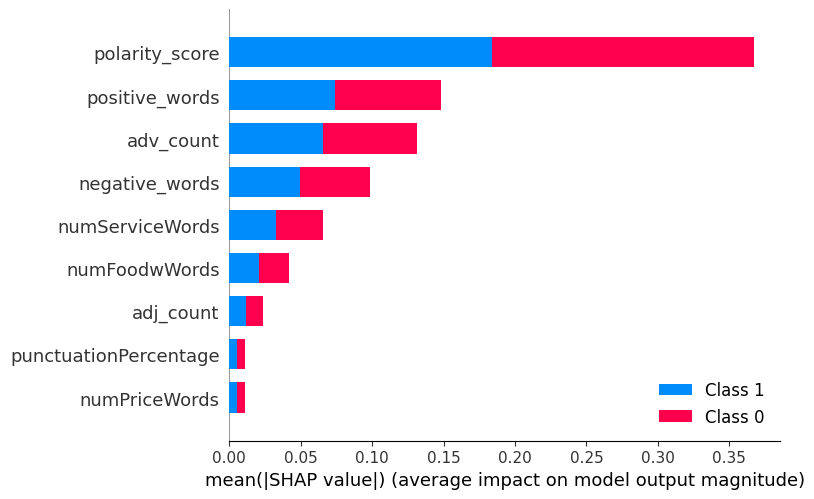

In [91]:
shap.summary_plot(shap_values, x_test, feature_names=feature_df24[['positive_words', 'negative_words','polarity_score', 'adj_count','adv_count'
                                                                ,'numServiceWords', 'numPriceWords','numFoodwWords', 'punctuationPercentage']].columns)

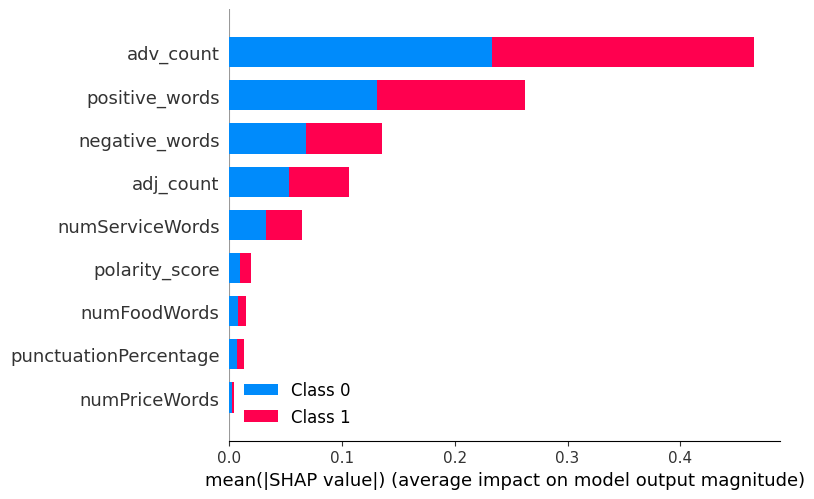

In [84]:
shap.summary_plot(shap_values, x_test, feature_names=feature_df[['positive_words', 'negative_words', 'polarity_score'
                                                                ,'adj_count', 'adv_count'
                                                                ,'numServiceWords', 'numPriceWords','numFoodWords', 'punctuationPercentage']].columns)

Investigation into stats about the star classes

In [44]:
lengths = []
for i in (list(albertaClean['text'])):
    length = word_tokenize(i)
    lengths.append(len(length))

albertaClean['reviewLength'] = lengths

C:\Users\User\AppData\Local\Temp\ipykernel_13848\3488293405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['reviewLength'] = lengths


In [45]:
starStats = albertaClean.groupby(by='review_stars').agg({
    'business_id' : 'nunique',
    'reviewLength': 'mean',
    'stars' : 'mean',
    'name' : 'count'
})
starStats['reviewLength'] = starStats['reviewLength'].round(2)

In [46]:
os = albertaClean[albertaClean['review_stars'] == 1]

In [47]:
noDups = os.groupby(by='business_id').aggregate({'stars': 'first'})

In [50]:
np.mean(list(noDups['stars']))

3.2746285085305447

In [51]:

starStats

,business_id,reviewLength,stars,name
review_stars,,,,
1,1817,149.06,3.074941,7586
2,1733,171.64,3.340298,6653
3,2009,171.18,3.516603,10420
4,2250,155.46,3.728002,21377
5,2129,119.09,3.947496,22846
